In [1]:
import torch
from torch import nn
from d2l import torch as d2l
import matplotlib.pyplot as plt
from tqdm import trange

### 定义模型

In [2]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers)

In [3]:
def vgg(conc_arch):
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for (num_convs, out_channels) in conc_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

In [4]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
net = vgg(conv_arch)

In [5]:
X = torch.rand(size=(1, 1, 224, 224), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, f'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


### 载入数据

In [6]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

### 模型准确率评估

In [7]:
def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

def evaluate_accuracy_gpu(net, data_iter, device='None'):
    if isinstance(net, nn.Module):
        net.eval()
        if not device:
            device = next(iter(net.parameters())).device
    
    num_accurate, num_sum = 0, 0
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            num_accurate += accuracy(net(X), y)
            num_sum += y.numel()
    return num_accurate / num_sum

### 模型训练

In [8]:
def train(net, train_iter, test_iter, num_epochs, lr, device='cuda'):
    # 参数初始化
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    # gpu 训练
    print('training on', device)
    net.to(device)
    # 定义优化器与损失函数
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    # 开始迭代
    train_list, test_list, loss_list = [], [], []
    for epoch in trange(num_epochs, desc="Training", unit="epoch"):
        net.train()
        l_sum, train_sum, num_sum = 0, 0, 0
        for X, y in train_iter:
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            optimizer.zero_grad()
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            # 计算过程
            with torch.no_grad():
                l_sum += l * X.shape[0]
                train_sum += accuracy(y_hat, y)
                num_sum += X.shape[0]
        test_ac = evaluate_accuracy_gpu(net, test_iter, device)
        train_list.append(train_sum / num_sum)
        test_list.append(test_ac)
        loss_list.append(l_sum / num_sum)
        
    return train_list, test_list, loss_list

In [9]:
num_epochs, lr = 10, 0.01
train_list, test_list, loss_list = train(net, train_iter, test_iter, num_epochs, lr, device='cuda')

training on cuda


Training: 100%|██████████| 10/10 [27:24<00:00, 164.41s/epoch]


### 训练结果

In [10]:
loss_list = [l.cpu() for l in loss_list]

最终 train_ac: 0.895, test_ac: 0.896


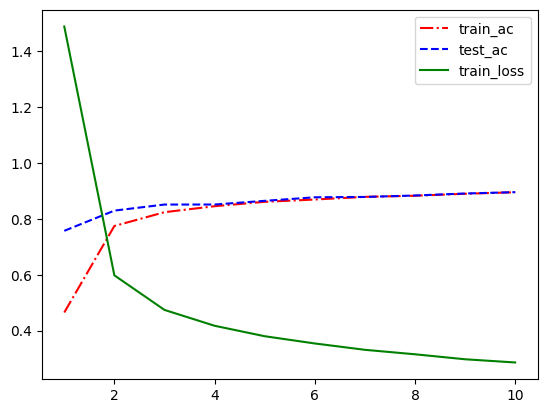

In [11]:
print(f'最终 train_ac: {train_list[-1]:.3f}, test_ac: {test_list[-1]:.3f}')
plt.plot(list(range(1, num_epochs+1)), train_list, color='red', linestyle='-.', label='train_ac')
plt.plot(list(range(1, num_epochs+1)), test_list, color='blue', linestyle='--', label='test_ac')
plt.plot(list(range(1, num_epochs+1)), loss_list, color='green', label='train_loss')
plt.legend()
plt.show()